In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

# Adam算法
`Adam`算法汇总了之前提到的一些优化算法的优点, 是深度学习中使用的更强大和有小的优化算法之一, 但是有时 `Adam` 算法可能由于方差控制不良导致发散, 之后提出了一个名为 `Yogi` 的热补丁来解决这些问题

## 算法
`Adam`算法的一个关键组成部分就是, 使用指数加权移动平均值来估算梯度的动量和二次矩, 也就是使用状态变量:
$$
\begin{align*}
\mathbf{v}_t &\leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t \\
\mathbf{s}_t &\leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2
\end{align*}
$$
一般可以设置 $\beta_1 = 0.9, \beta_2 = 0.999$, 也就是方差估计的一定慢于动量轨迹的移动($\mathbf{v}_t$ 表示动量, $\mathbf{g}_t$ 表示方差), 同时为了消除初始偏移, 这里可以通过 $\sum_{i=0}^t \beta^i = \frac {1 - \beta^t}{1 - \beta}$, 标准化状态变量如下:
$$
\hat{\mathbf{v}}_t = \frac {\mathbf{v}_t}{1 - \beta_1^t} \ and \ \hat{\mathbf{s}}_t = \frac {\mathbf{s}_t}{1 - \beta_2^t}
$$
并且此时可以使用类似于 `RMSProp`算法的方式来重新缩放梯度从而得到:
$$
\mathbf{g'}_t = \frac {\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{v}}_t} + \epsilon}
$$
最后进行简单更新即可:
$$
\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g'}_t
$$

## 实现
这里使用 `PyTorch API` 提供的 `torch.optim.Adam` 算法来实现 `Adam` 算法:
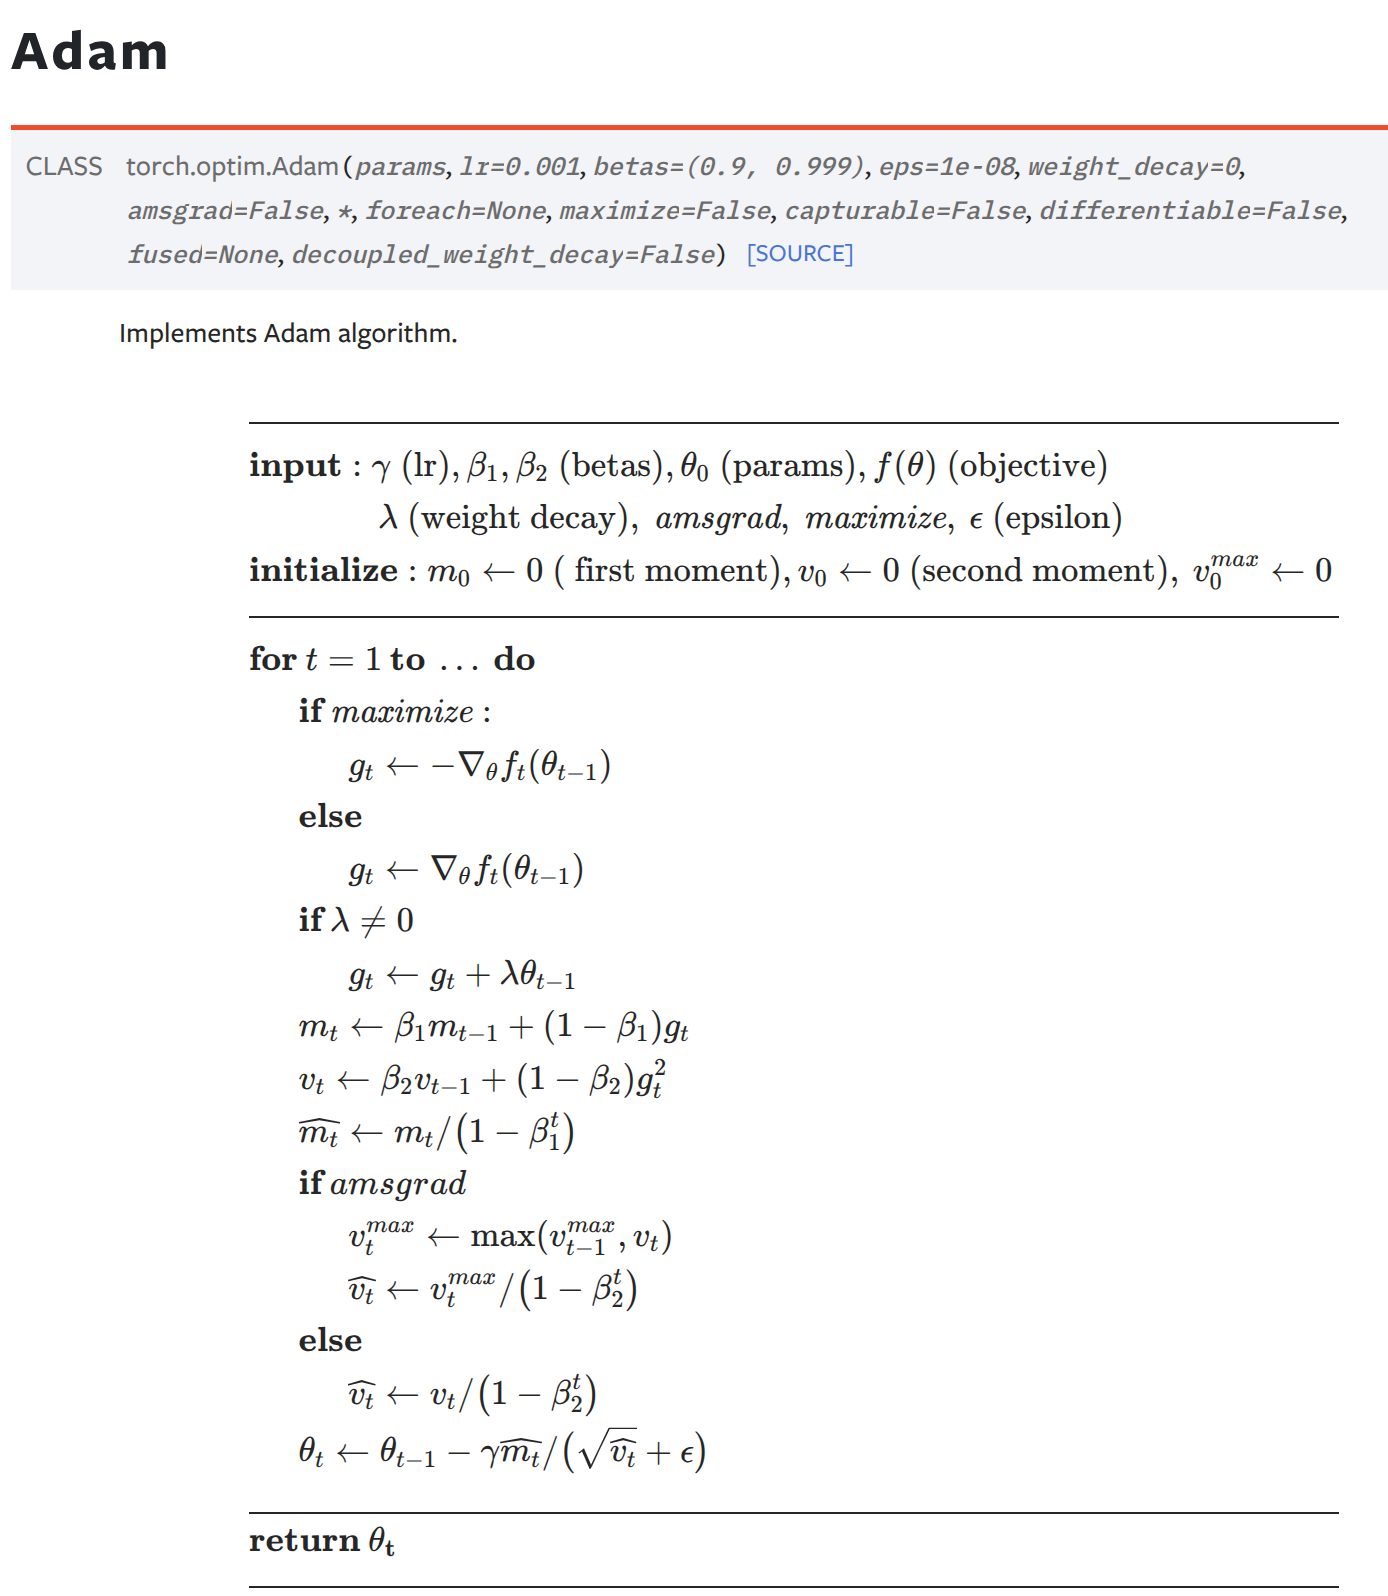

loss: 0.246, 0.058 sec/epoch


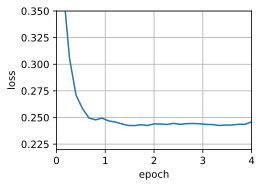

In [2]:
data_iter, _ = d2l.get_data_ch11(batch_size=10)
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01} , data_iter)

## Yogi
`Adam`算法存在的问题: 在凸环境中, 当 $\mathbf{s}_t$ 的二次矩估计值爆炸的时候, 可能无法收敛, $\mathbf{s}_t$ 剔除了改进更新和参数初始化, 更新公式如下:
$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2)(\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$
另外如果梯度方差比较大的情况下, $\mathbf{s}_t$ 可能会忘记过去的值, 一个有效的方法就是可以把 $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ 替换, 所以更新式如下:
$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \operatorname{sgn}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).
$$